# Qubit routing using Layout optimization with help of approximation schema

We use a modified Minimal-Spanning-Tree (MST) Approximation schema (Christofides algorithm) to generate an optimized mapping of the virtual qubits in the quantum circuit to physical qubits on the quantum device.

In [1]:
from qiskit import QuantumCircuit
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

from optimized_routing.utils.backend_info import get_backend

In [2]:
noisy_fake_backend = get_backend(backend_name='ibm_brisbane')

## Example FullAdder circuit

In [3]:
qc = QuantumCircuit(5, 2)

# Full Adder logic
qc.cx(0, 3)         # A ⊕
qc.cx(1, 3)         # B ⊕ → sum = A⊕B⊕Cin
qc.ccx(0, 1, 4)     # A & B → carry
qc.cx(2, 3)         # Cin ⊕
qc.ccx(2, 3, 4)     # carry from Cin ⊕ sum

# Measure outputs
qc.measure(3, 0)  # Sum
qc.measure(4, 1)  # Carry out

# Rename circuit
FullAdder=qc

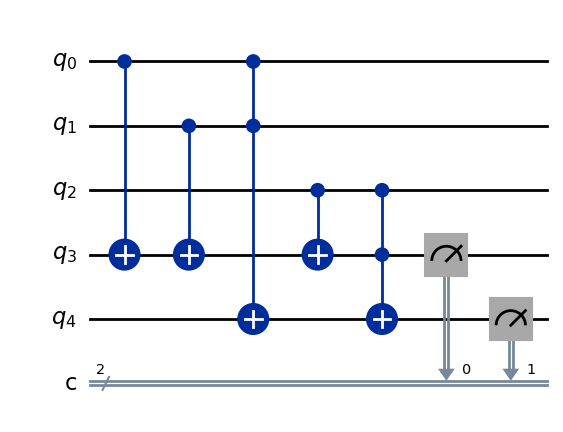

In [4]:
FullAdder.draw('mpl')

## Draw the virtual circuit in the form of a graph

In [5]:
import rustworkx as rx
from rustworkx.visualization import mpl_draw
import numpy as np

In [6]:
graph = rx.PyDiGraph()

graph.add_nodes_from(np.arange(0, FullAdder.num_qubits, 1))

graph.add_edge(0, 3, 5)
graph.add_edge(1, 3, 5)
graph.add_edge(0, 1, 5)
graph.add_edge(1, 4, 5)
graph.add_edge(2, 3, 5)
graph.add_edge(3, 4, 5)

5

Virtual circuit qubit connectivity of FullAdder


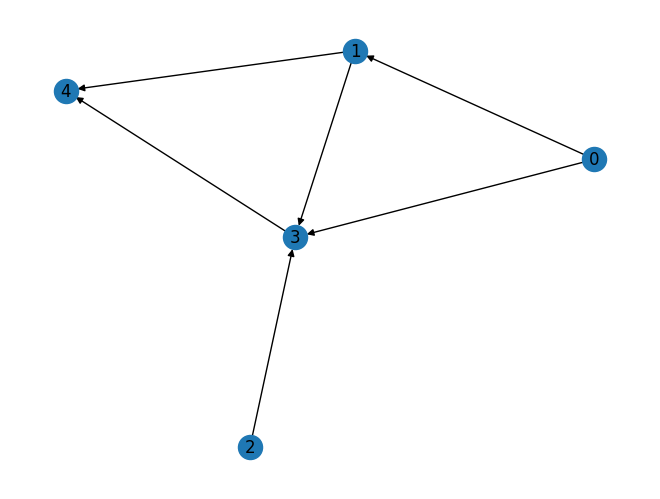

In [7]:
print("Virtual circuit qubit connectivity of FullAdder")
mpl_draw(graph, with_labels=True,)

## Passmanager with custom layout

In [8]:
from qiskit.transpiler.layout import Layout
from optimized_routing.layout.mst_layout import generate_mst_layout
from qiskit.visualization import plot_error_map

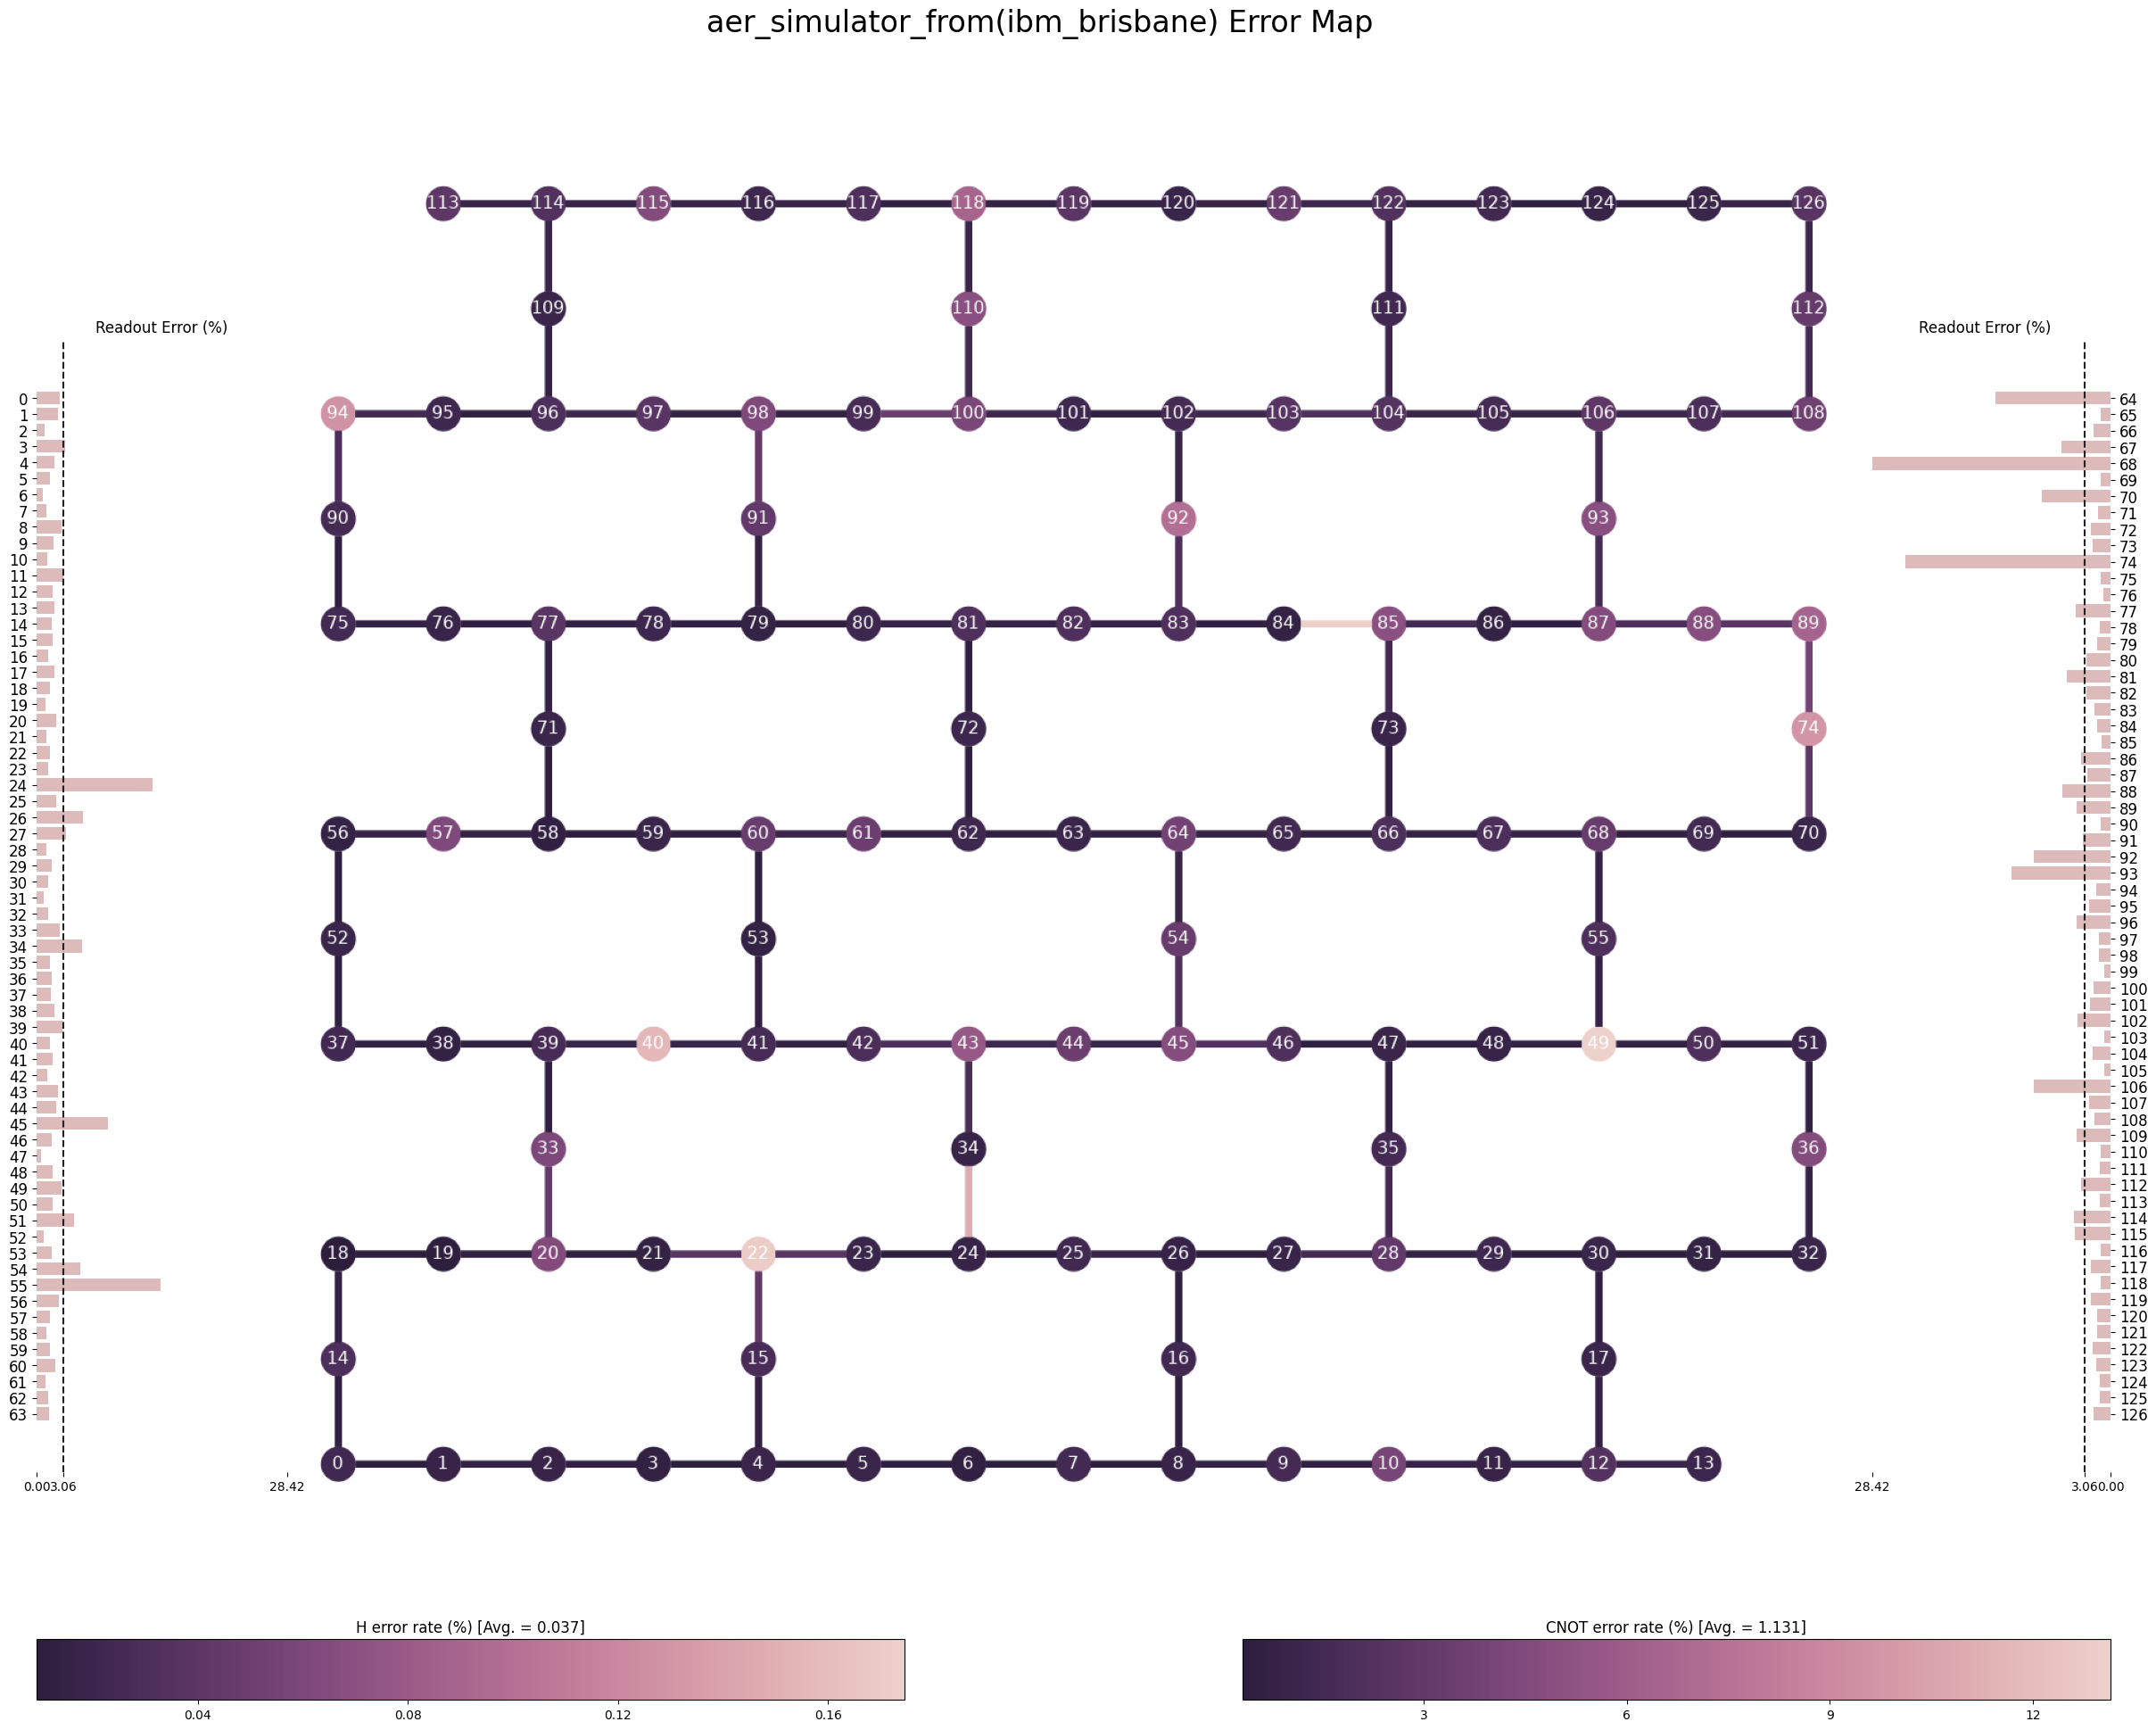

In [9]:
plot_error_map(noisy_fake_backend, figsize=(30, 24))

In [10]:
# Custom layout using Minimal spanning tree approximation schema
qopt_layout = generate_mst_layout(backend=noisy_fake_backend, qc=FullAdder)
print(qopt_layout)

Layout({
0: <Qubit register=(5, "q"), index=0>,
1: <Qubit register=(5, "q"), index=1>,
2: <Qubit register=(5, "q"), index=2>,
3: <Qubit register=(5, "q"), index=3>,
4: <Qubit register=(5, "q"), index=4>
})


In [11]:
phys_graph = rx.PyDiGraph()

phys_graph.add_nodes_from(np.arange(0, FullAdder.num_qubits, 1))

phys_graph.add_edge(0, 1, 5)
phys_graph.add_edge(1, 2, 5)
phys_graph.add_edge(2, 3, 5)
phys_graph.add_edge(3, 4, 5)

3

Physical circuit qubit connectivity of on ibm_brisbane


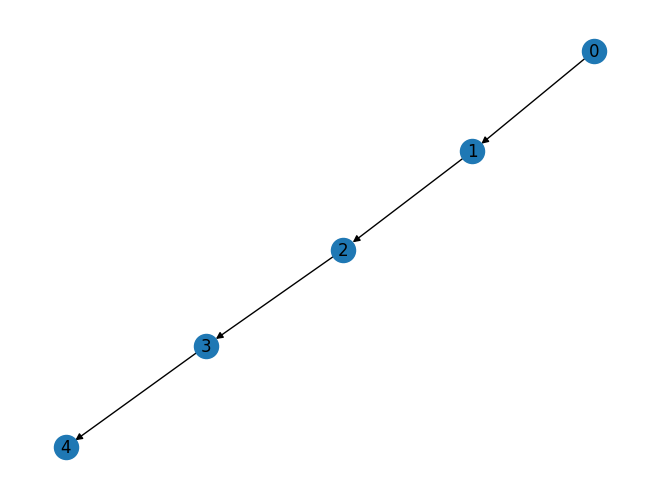

In [12]:
print("Physical circuit qubit connectivity of on ibm_brisbane")
mpl_draw(phys_graph, with_labels=True,)

## Transpiled circuit

In [13]:
pm0 = generate_preset_pass_manager(backend=noisy_fake_backend, optimization_level=0)
pm1 = generate_preset_pass_manager(backend=noisy_fake_backend, optimization_level=1)
pm2 = generate_preset_pass_manager(backend=noisy_fake_backend, optimization_level=2)
pm3 = generate_preset_pass_manager(backend=noisy_fake_backend, optimization_level=3)

In [14]:
pm_qopt = generate_preset_pass_manager(
    backend=noisy_fake_backend,
    optimization_level=0,
    seed_transpiler=42,
    initial_layout=qopt_layout,
    layout_method='trivial'
)

In [15]:
isa_circuit_qopt = pm_qopt.run(FullAdder)

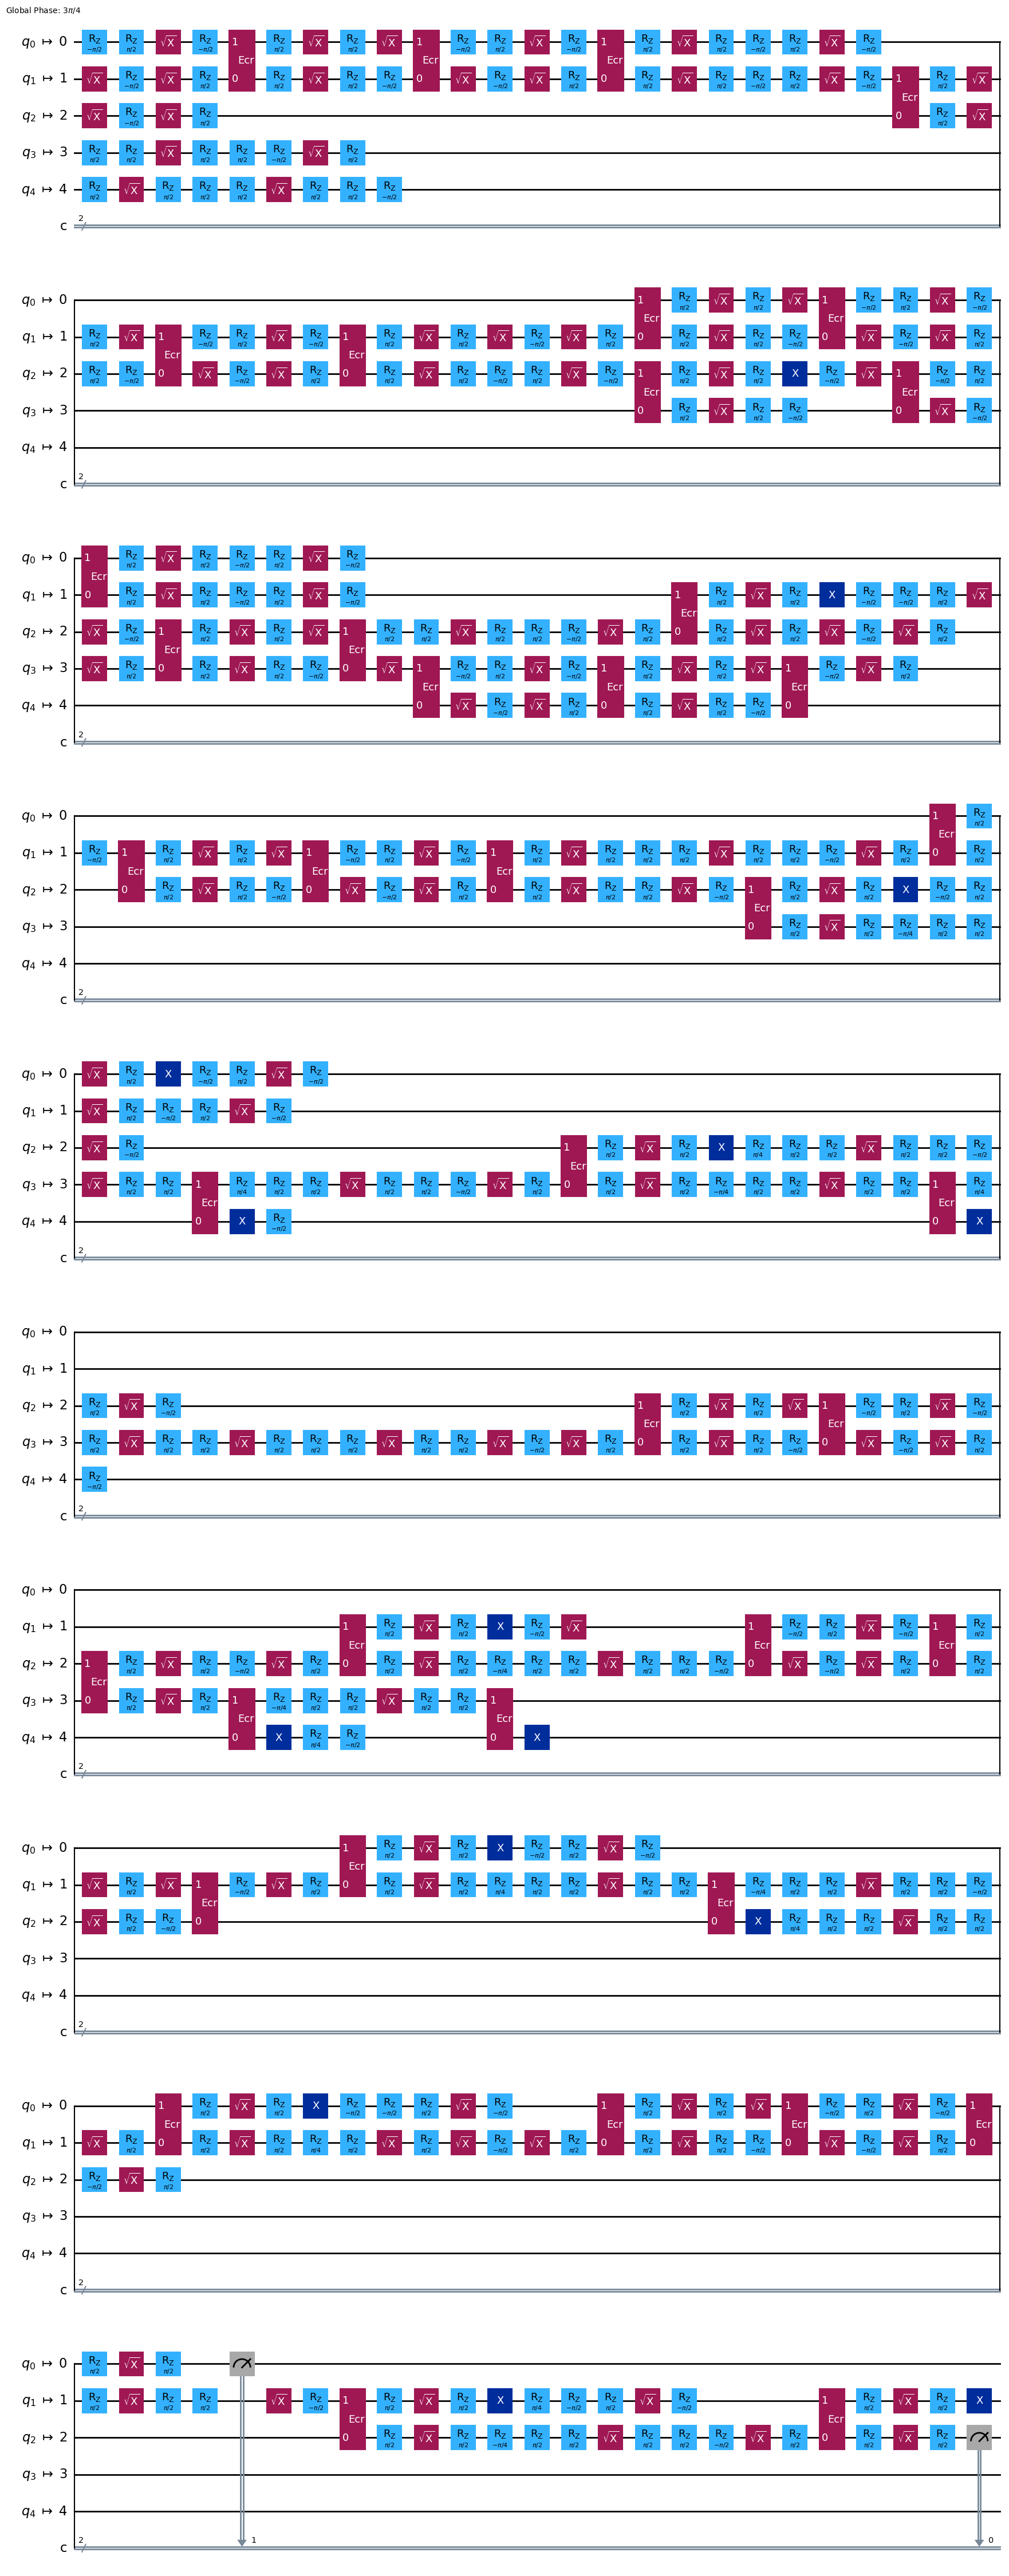

In [16]:
isa_circuit_qopt.draw('mpl')

In [17]:
isa_circuit_l0 = pm0.run(FullAdder)
isa_circuit_l1 = pm1.run(FullAdder)
isa_circuit_l2 = pm2.run(FullAdder)
isa_circuit_l3 = pm3.run(FullAdder)

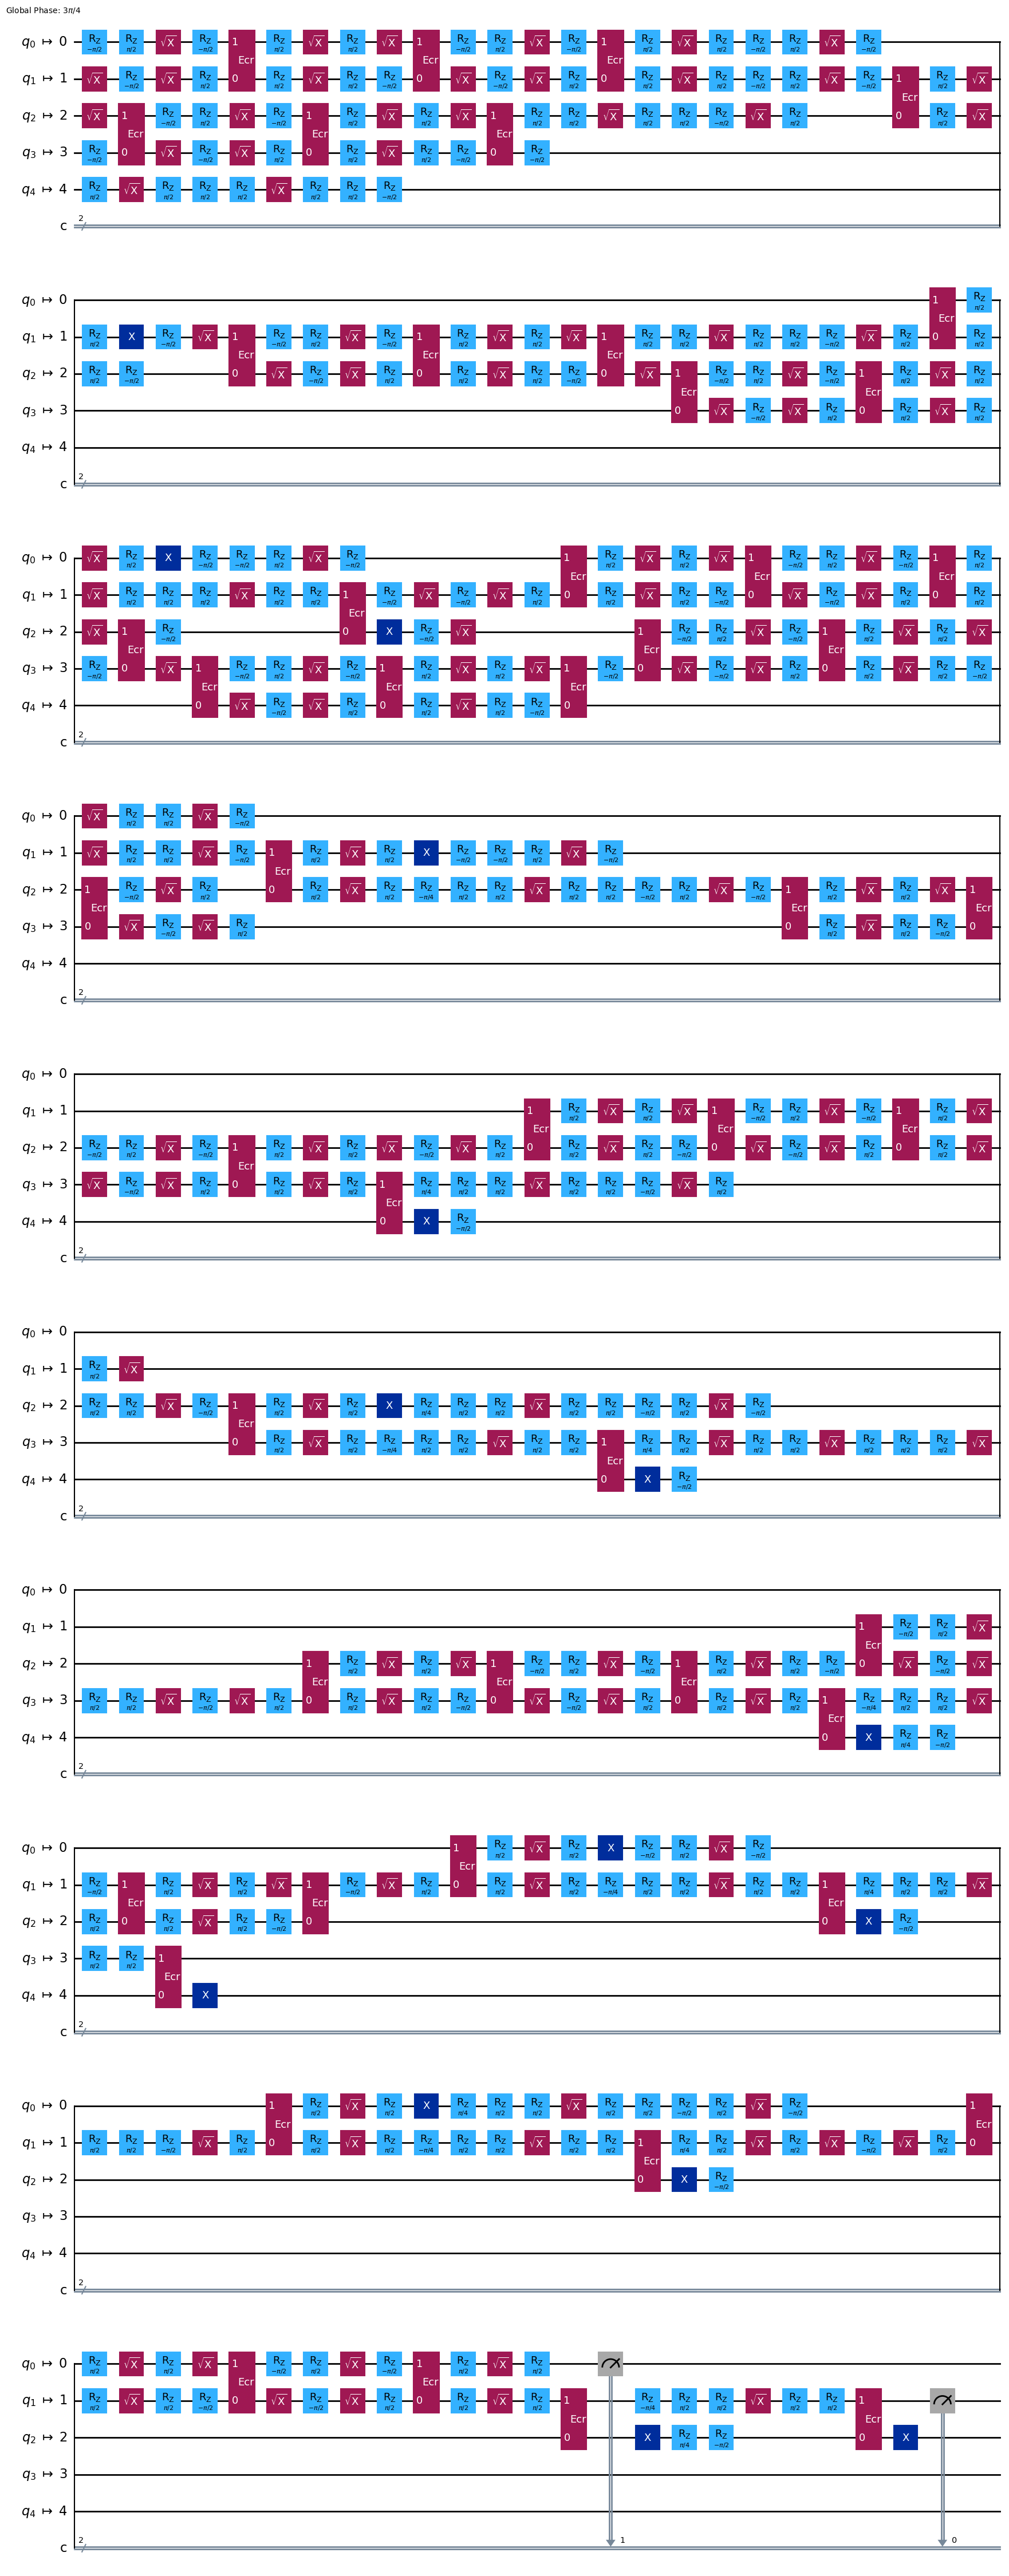

In [18]:
isa_circuit_l0.draw('mpl')

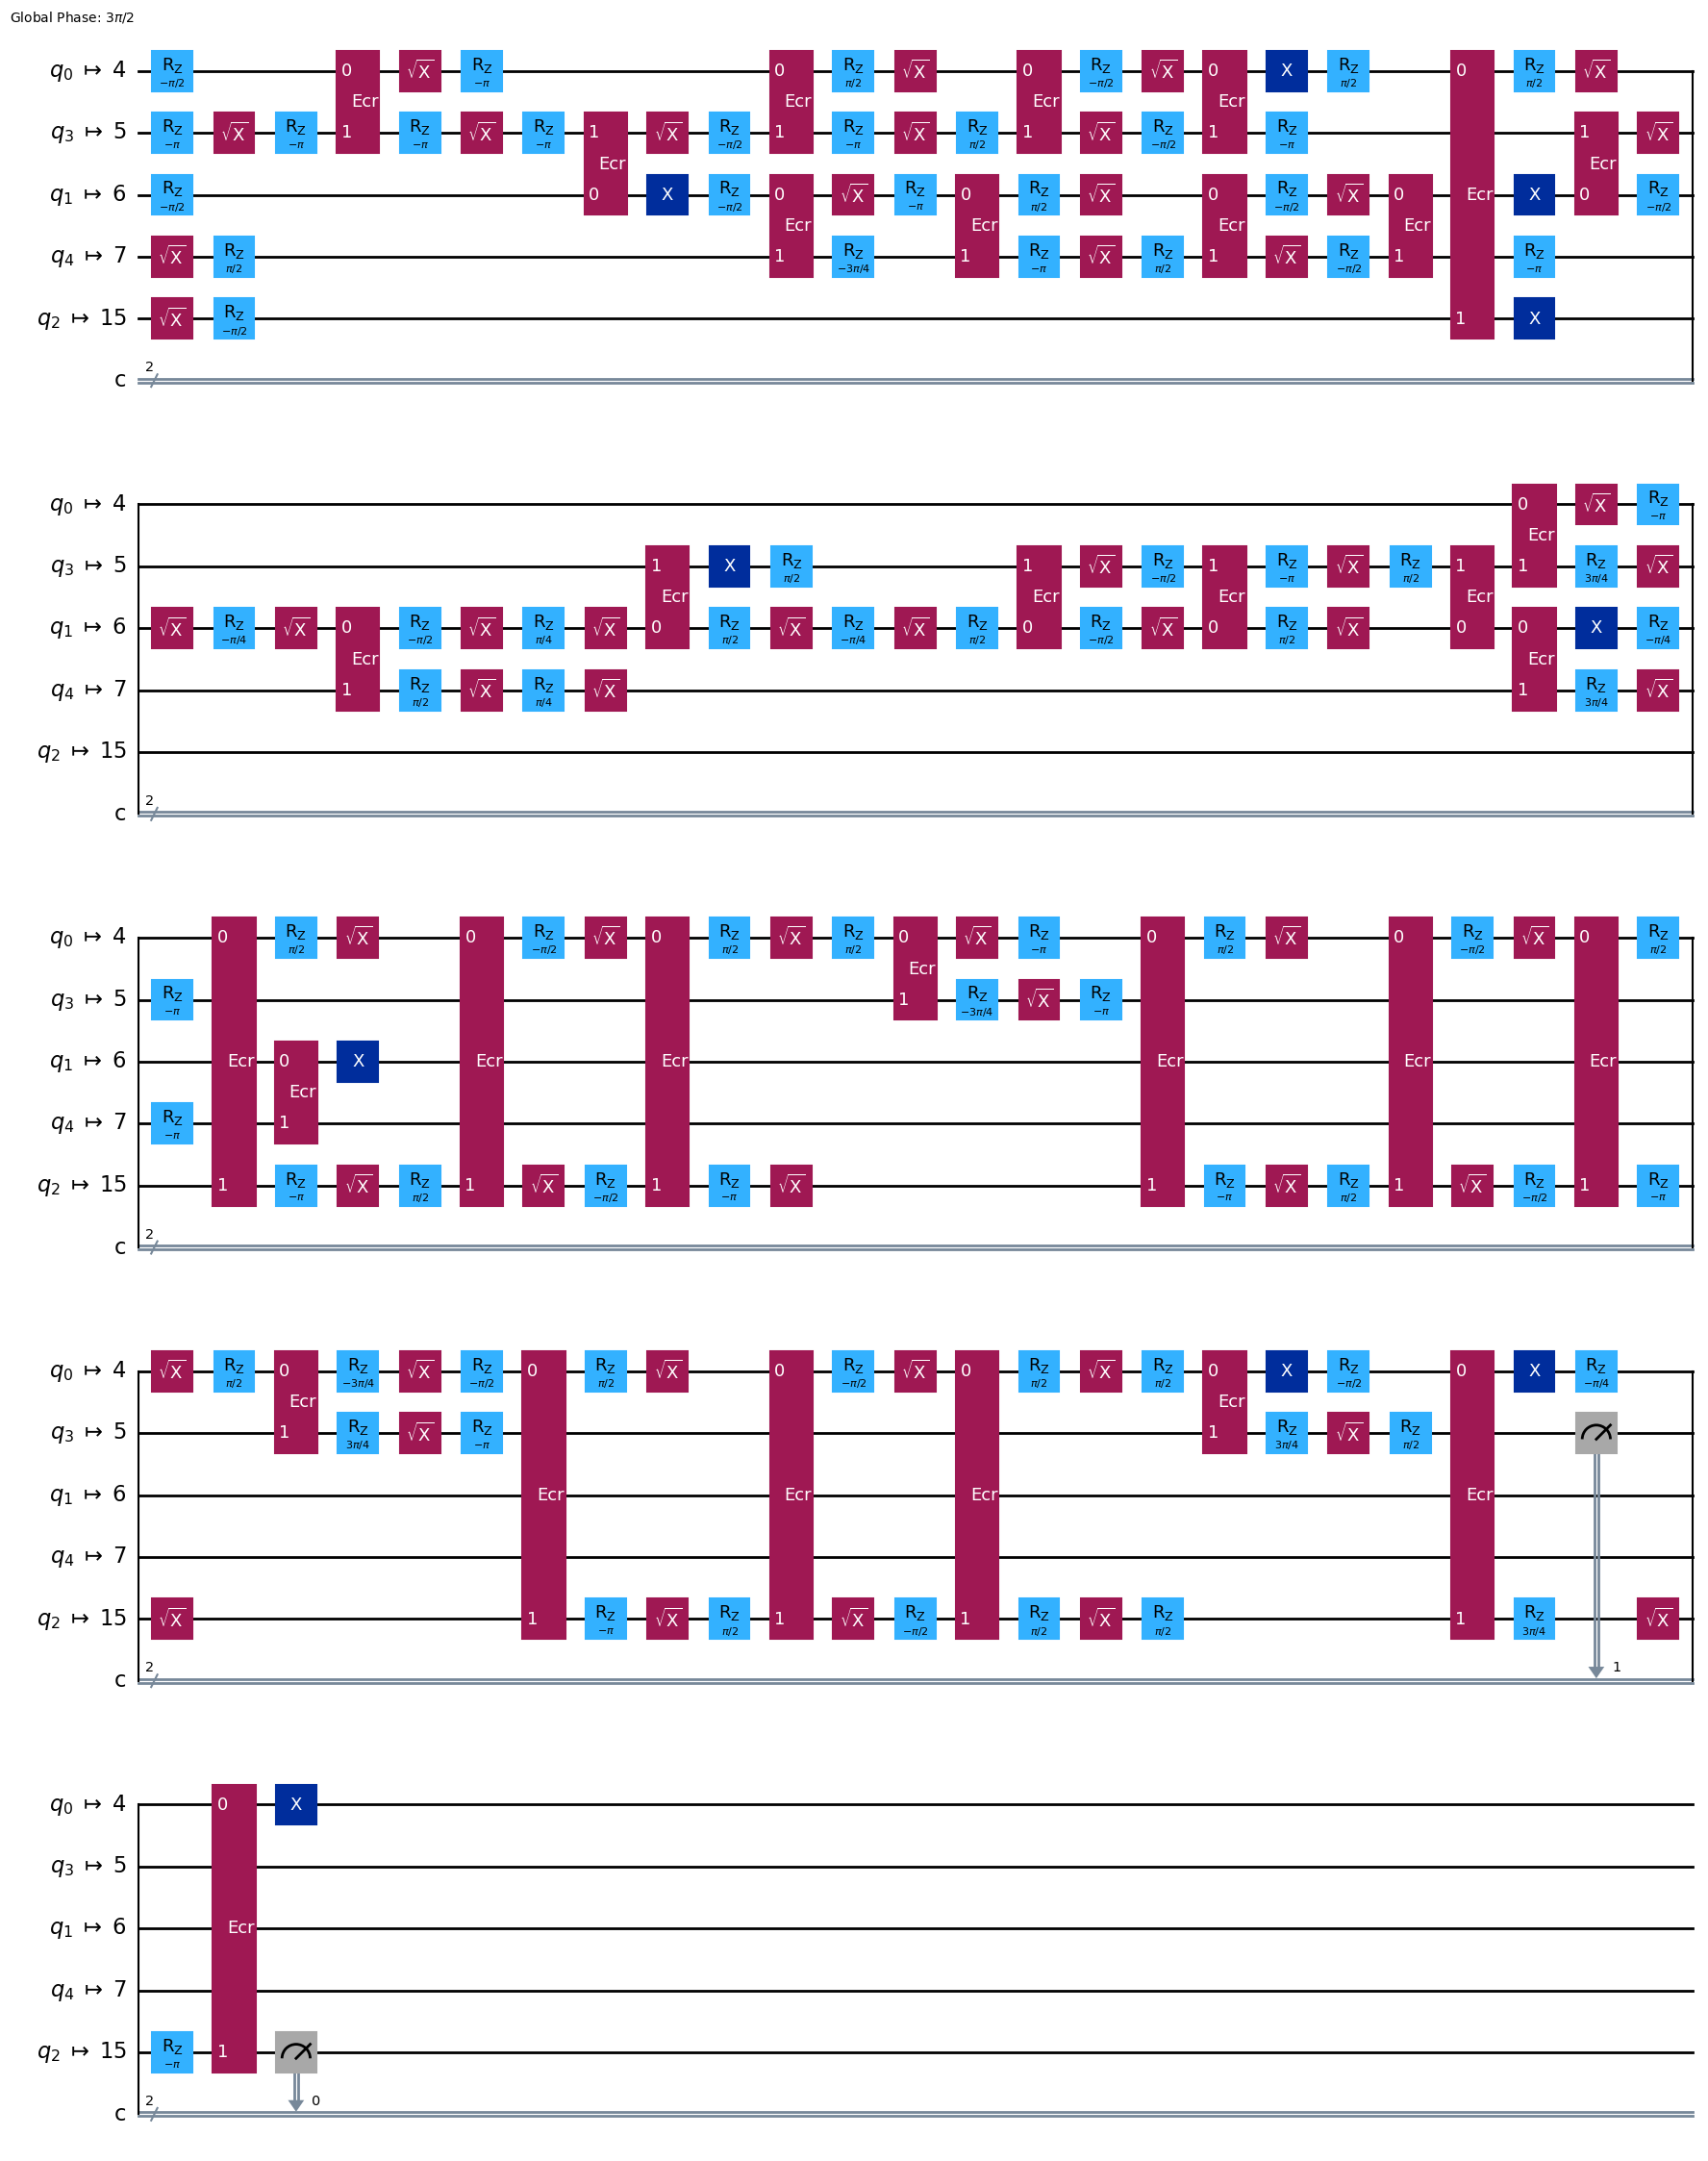

In [19]:
isa_circuit_l1.draw('mpl')

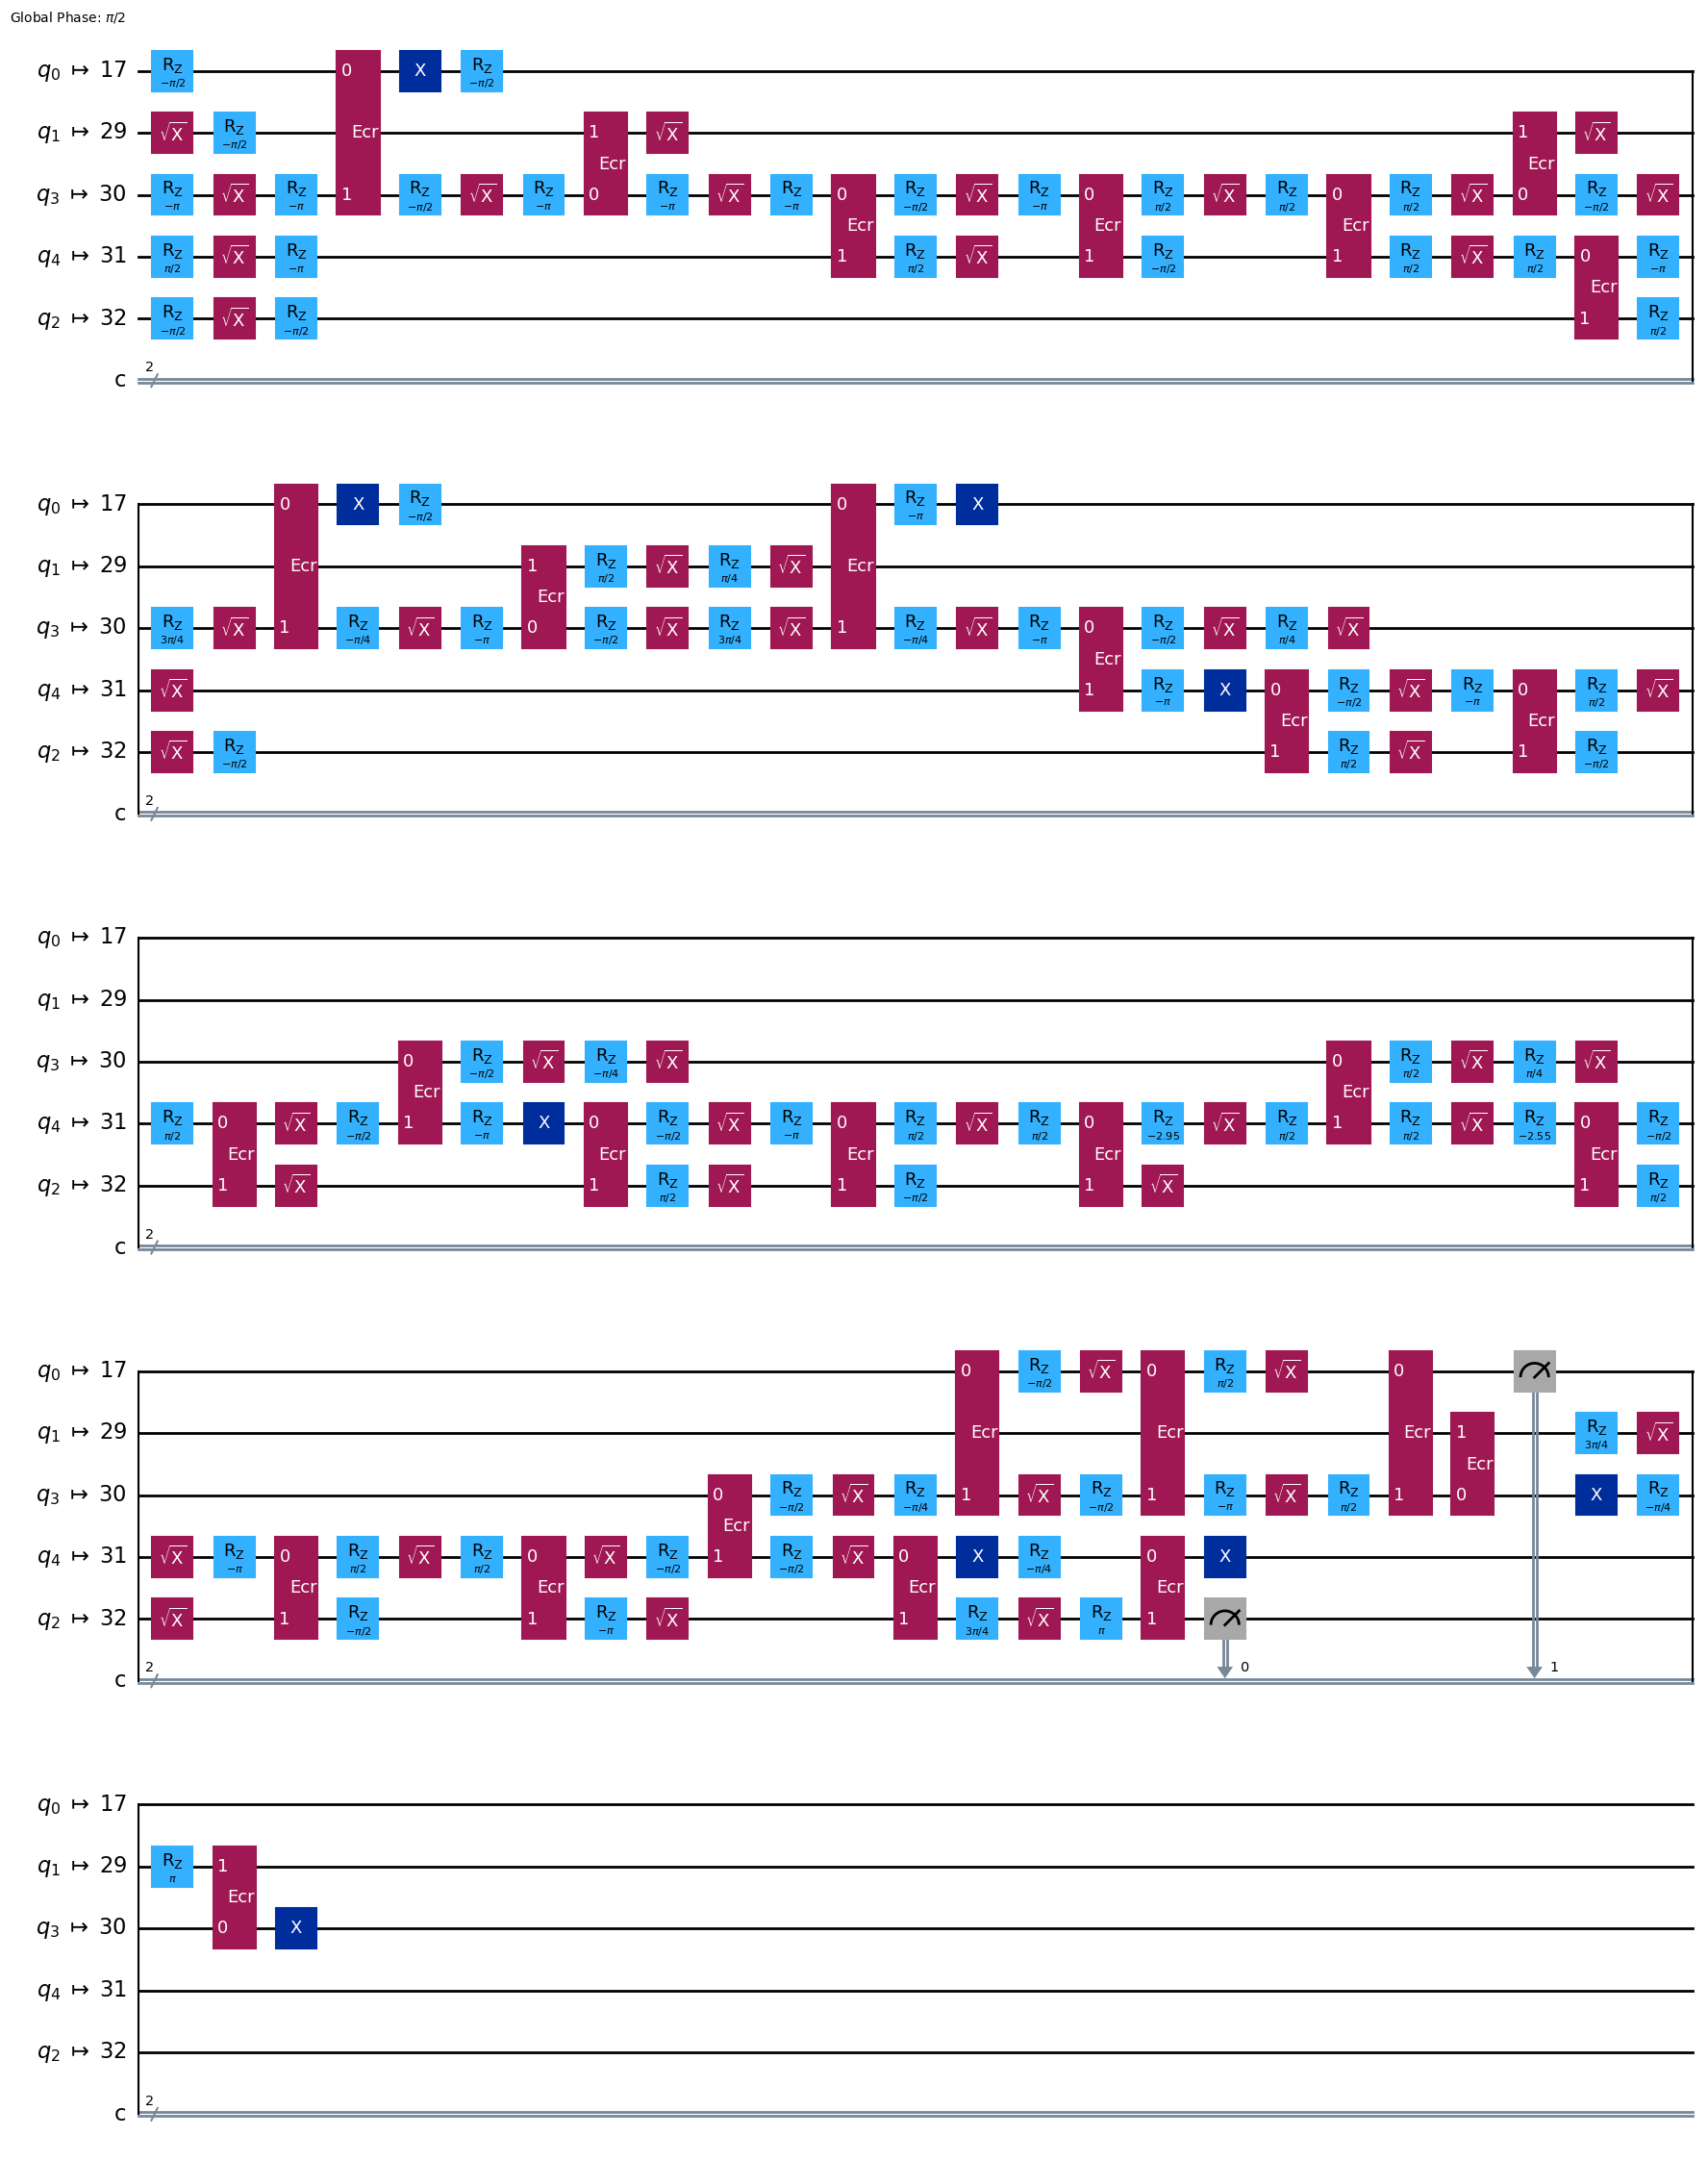

In [20]:
isa_circuit_l2.draw('mpl')

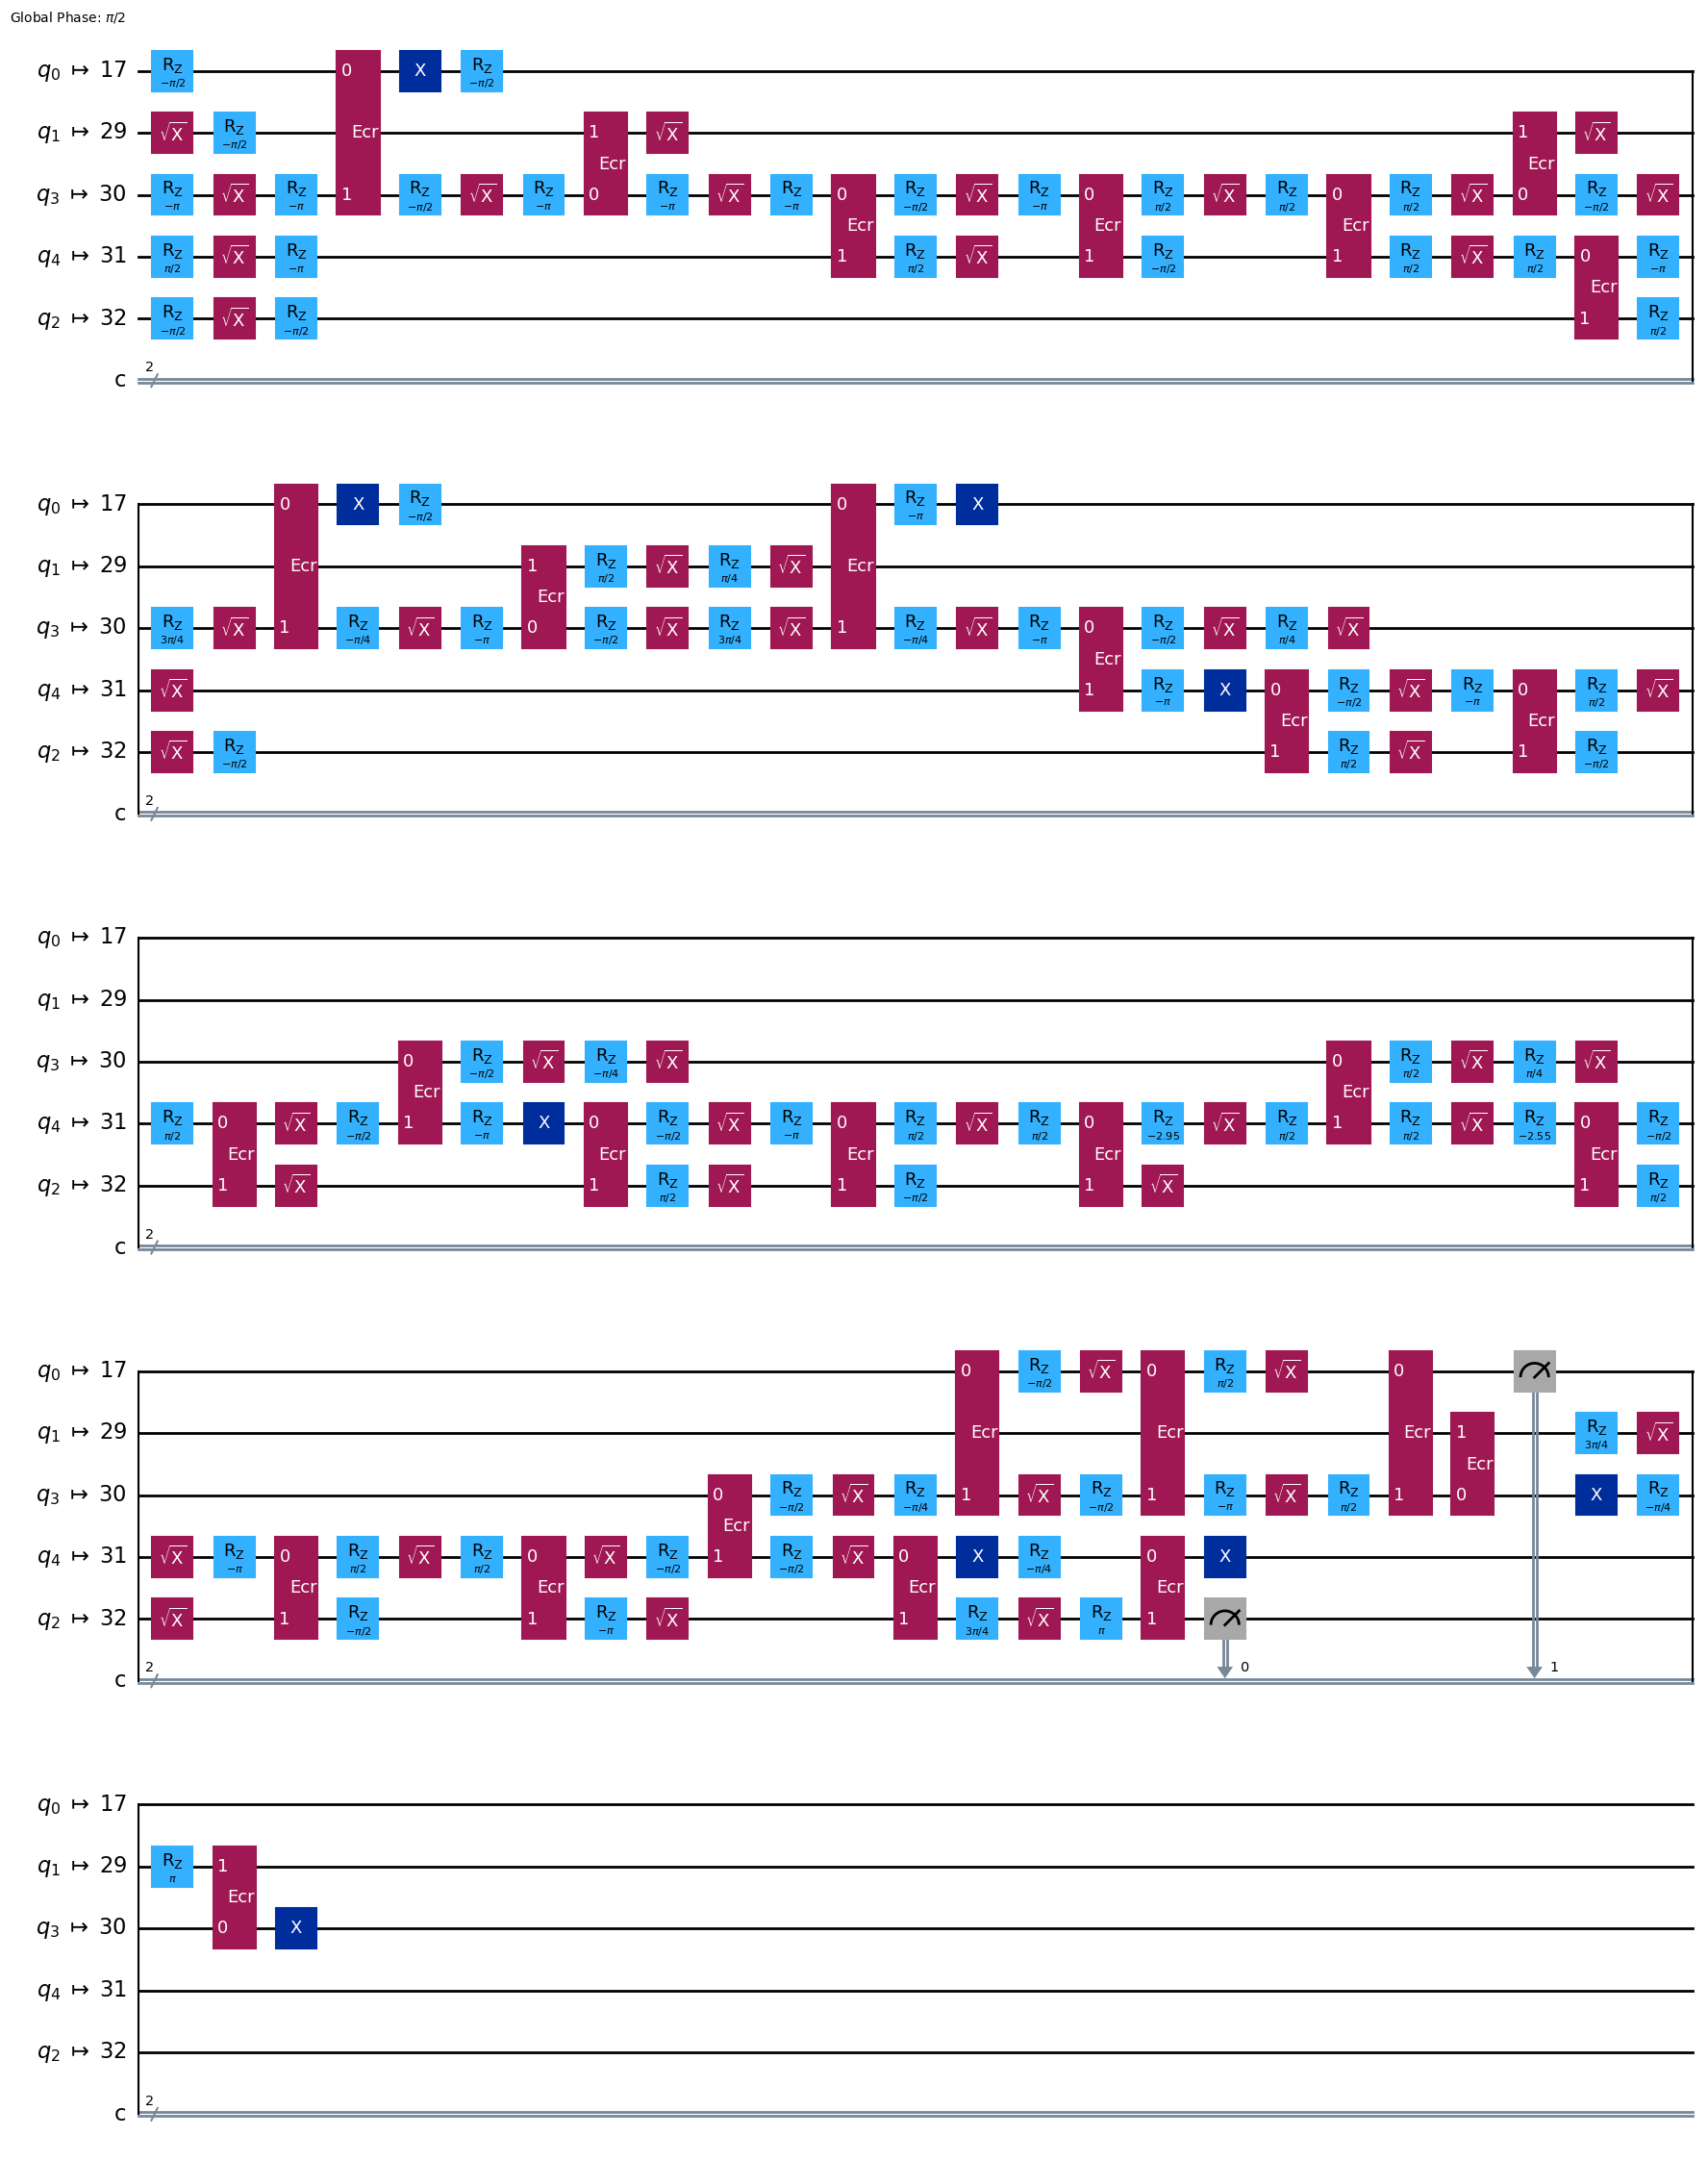

In [21]:
isa_circuit_l3.draw('mpl')

## Benchmarking the layouts

In [22]:
import time
import matplotlib.pyplot as plt

Optimization level: 0
Transpilation time (sec.): 0.008831977844238281
Circuit depth: 279
------------------------------------------------------------------------------------------------------------------------------------------------------
Optimization level: 1
Transpilation time (sec.): 0.018744230270385742
Circuit depth: 101
------------------------------------------------------------------------------------------------------------------------------------------------------
Optimization level: 2
Transpilation time (sec.): 0.016782045364379883
Circuit depth: 105
------------------------------------------------------------------------------------------------------------------------------------------------------
Optimization level: 3
Transpilation time (sec.): 0.021474123001098633
Circuit depth: 106
------------------------------------------------------------------------------------------------------------------------------------------------------


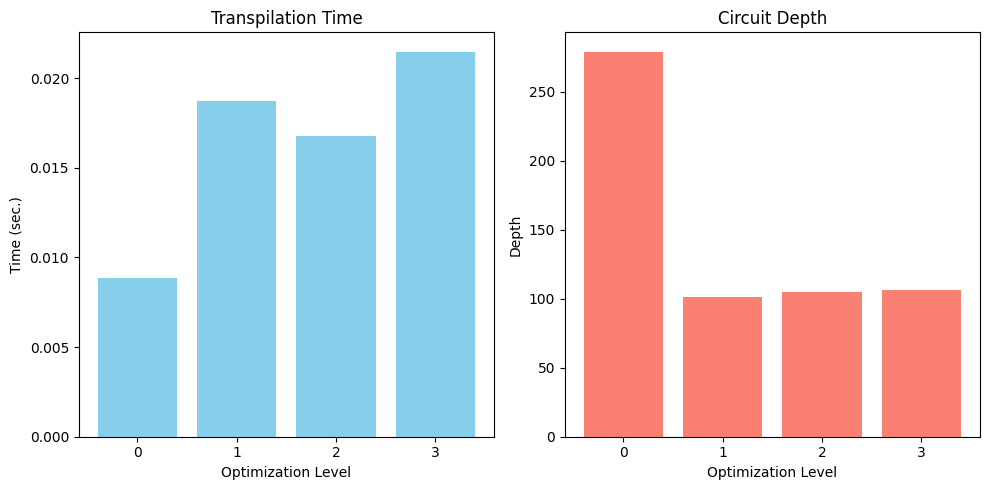

In [23]:
times = []
depths = []
### WRITE YOUR CODE HERE ###
# Sweep over different optimization levels
optimization_levels = [0,1,2,3]
for level in optimization_levels:
    pm = generate_preset_pass_manager(backend=noisy_fake_backend, optimization_level=level)
    ### YOUR CODE FINISHES HERE ###
    print('\033[1m' + f'Optimization level: {level}')
    start = time.time()
    isa_qc = pm.run(FullAdder)
    dt = time.time() - start
    times.append(dt)
    depth = isa_qc.depth()
    depths.append(depth)

    print('Transpilation time (sec.):', dt)
    print('Circuit depth:', depth)
    print('---' * 50)

# Plotting
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.bar([str(lvl) for lvl in optimization_levels], times, color='skyblue')
plt.title('Transpilation Time')
plt.xlabel('Optimization Level')
plt.ylabel('Time (sec.)')

plt.subplot(1, 2, 2)
plt.bar([str(lvl) for lvl in optimization_levels], depths, color='salmon')
plt.title('Circuit Depth')
plt.xlabel('Optimization Level')
plt.ylabel('Depth')

plt.tight_layout()
plt.show()


Optimization level: 0
Transpilation time (sec.): 0.010075569152832031
Circuit depth: 249
------------------------------------------------------------------------------------------------------------------------------------------------------
Optimization level: 1
Transpilation time (sec.): 0.010272026062011719
Circuit depth: 149
------------------------------------------------------------------------------------------------------------------------------------------------------
Optimization level: 2
Transpilation time (sec.): 0.009629249572753906
Circuit depth: 159
------------------------------------------------------------------------------------------------------------------------------------------------------
Optimization level: 3
Transpilation time (sec.): 0.01726841926574707
Circuit depth: 159
------------------------------------------------------------------------------------------------------------------------------------------------------


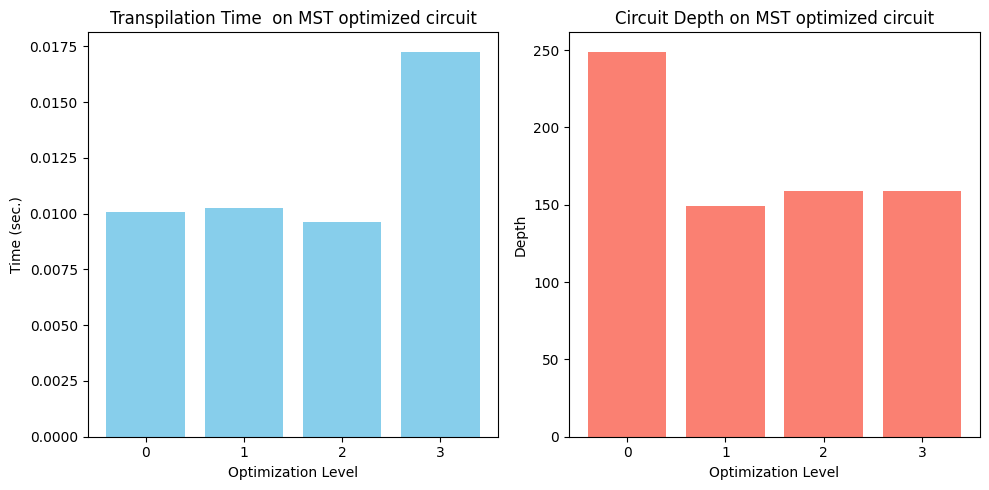

In [24]:
times = []
depths = []
### WRITE YOUR CODE HERE ###
# Sweep over different optimization levels
optimization_levels = [0,1,2,3]
for level in optimization_levels:
    pm = generate_preset_pass_manager(backend=noisy_fake_backend, initial_layout=qopt_layout,
                                      layout_method='trivial', optimization_level=level, seed_transpiler=42)
    ### YOUR CODE FINISHES HERE ###
    print('\033[1m' + f'Optimization level: {level}')
    start = time.time()
    isa_qc = pm.run(FullAdder)
    dt = time.time() - start
    times.append(dt)
    depth = isa_qc.depth()
    depths.append(depth)

    print('Transpilation time (sec.):', dt)
    print('Circuit depth:', depth)
    print('---' * 50)

# Plotting
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.bar([str(lvl) for lvl in optimization_levels], times, color='skyblue')
plt.title('Transpilation Time  on MST optimized circuit')
plt.xlabel('Optimization Level')
plt.ylabel('Time (sec.)')

plt.subplot(1, 2, 2)
plt.bar([str(lvl) for lvl in optimization_levels], depths, color='salmon')
plt.title('Circuit Depth on MST optimized circuit')
plt.xlabel('Optimization Level')
plt.ylabel('Depth')

plt.tight_layout()
plt.show()


Layout method: trivial
Transpilation time (sec.): 0.01330876350402832
Circuit depth: 159
------------------------------------------------------------------------------------------------------------------------------------------------------
Layout method: sabre
Transpilation time (sec.): 0.019618988037109375
Circuit depth: 100
------------------------------------------------------------------------------------------------------------------------------------------------------
Layout method: dense
Transpilation time (sec.): 0.012434720993041992
Circuit depth: 166
------------------------------------------------------------------------------------------------------------------------------------------------------
Layout method: default
Transpilation time (sec.): 0.017625093460083008
Circuit depth: 99
------------------------------------------------------------------------------------------------------------------------------------------------------
Layout method: qopt
Transpilation time (se

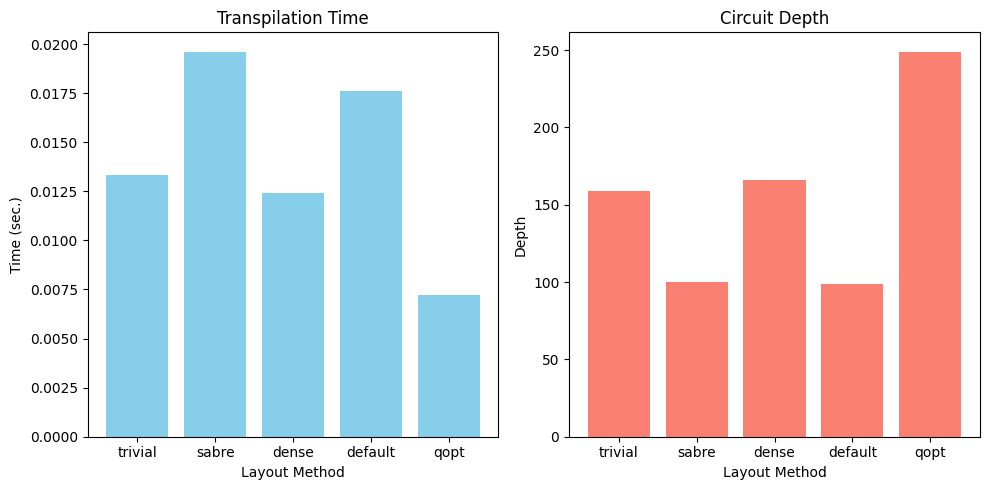

In [25]:
times = []
depths = []
# Sweep over layout methods
### WRITE YOUR CODE HERE ###
layout_methods = ['trivial', 'sabre', 'dense', 'default', 'qopt']
for layout_method in layout_methods:
    if layout_method == 'qopt':
        pm = pm_qopt
    else:
        pm = generate_preset_pass_manager(backend=noisy_fake_backend, layout_method=layout_method)
    ### YOUR CODE FINISHES HERE
    print('\033[1m' + f'Layout method: {layout_method}')
    start = time.time()
    isa_qc = pm.run(FullAdder)
    dt = time.time() - start
    times.append(dt)
    depth = isa_qc.depth()
    depths.append(depth)

    print('Transpilation time (sec.):', dt)
    print('Circuit depth:', depth)
    print('---' * 50)

# Identify the layout method with the smallest depth
min_depth_index = depths.index(min(depths))
best_layout = layout_methods[min_depth_index]
min_depth = depths[min_depth_index]

print(f"\nBest layout method: {best_layout} with smallest circuit depth of {min_depth}.")

# Plotting
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.bar(layout_methods, times, color='skyblue')
plt.title('Transpilation Time')
plt.xlabel('Layout Method')
plt.ylabel('Time (sec.)')

plt.subplot(1, 2, 2)
plt.bar(layout_methods, depths, color='salmon')
plt.title('Circuit Depth')
plt.xlabel('Layout Method')
plt.ylabel('Depth')

plt.tight_layout()
plt.show()


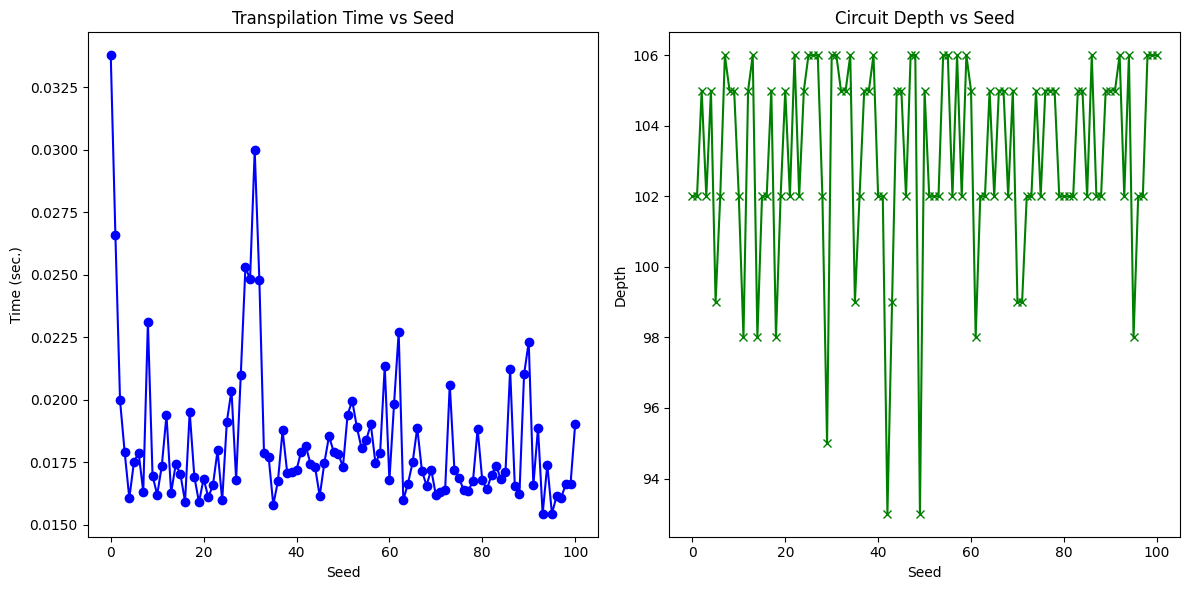

In [26]:
times = []
depths = []
### WRITE YOUR CODE HERE ###
# Sweep over seed_transpiler values
seed_values = [i for i in range(101)]
for seed in seed_values:
    pm = generate_preset_pass_manager(backend=noisy_fake_backend, optimization_level=2, seed_transpiler=seed)
    ### YOUR CODE FINISHES HERE
    start = time.time()
    isa_qc = pm.run(FullAdder)
    dt = time.time() - start
    times.append(dt)
    depths.append(isa_qc.depth())

# Plotting
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(seed_values, times, marker='o', linestyle='-', color='blue')
plt.title('Transpilation Time vs Seed')
plt.xlabel('Seed')
plt.ylabel('Time (sec.)')

plt.subplot(1, 2, 2)
plt.plot(seed_values, depths, marker='x', linestyle='-', color='green')
plt.title('Circuit Depth vs Seed')
plt.xlabel('Seed')
plt.ylabel('Depth')

plt.tight_layout()
plt.show()


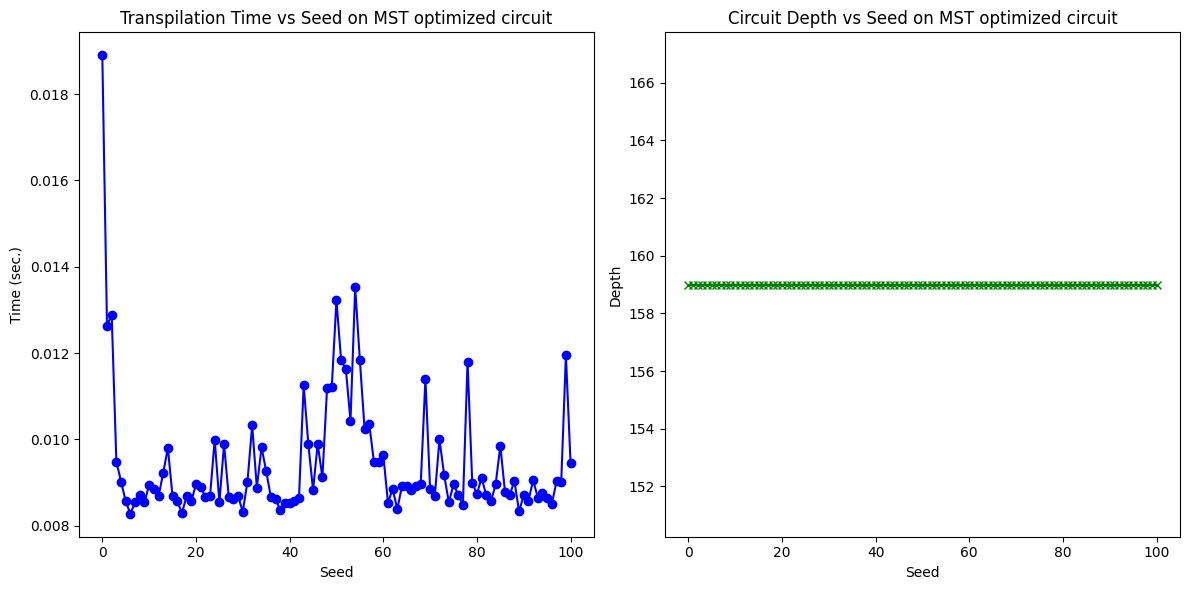

In [27]:
times = []
depths = []
### WRITE YOUR CODE HERE ###
# Sweep over seed_transpiler values
seed_values = [i for i in range(101)]
for seed in seed_values:
    pm = generate_preset_pass_manager(backend=noisy_fake_backend, initial_layout=qopt_layout,
                                      layout_method='trivial', optimization_level=2, seed_transpiler=seed)
    ### YOUR CODE FINISHES HERE
    start = time.time()
    isa_qc = pm.run(FullAdder)
    dt = time.time() - start
    times.append(dt)
    depths.append(isa_qc.depth())

# Plotting
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(seed_values, times, marker='o', linestyle='-', color='blue')
plt.title('Transpilation Time vs Seed on MST optimized circuit')
plt.xlabel('Seed')
plt.ylabel('Time (sec.)')

plt.subplot(1, 2, 2)
plt.plot(seed_values, depths, marker='x', linestyle='-', color='green')
plt.title('Circuit Depth vs Seed on MST optimized circuit')
plt.xlabel('Seed')
plt.ylabel('Depth')

plt.tight_layout()
plt.show()
